In [1]:
from collections import Counter
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import matplotlib.gridspec as gridspec
%matplotlib notebook

In [2]:
__author__ = 'Robert Fisher, rafish90@gmail.com'

In [3]:
data = pd.read_csv("C:\\Users\\M0185RK\\Desktop\\Python\\DataSets\\creditcardfraud\\creditcard.csv")

VISUALIZE THE DATA

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<IPython.core.display.Javascript object>


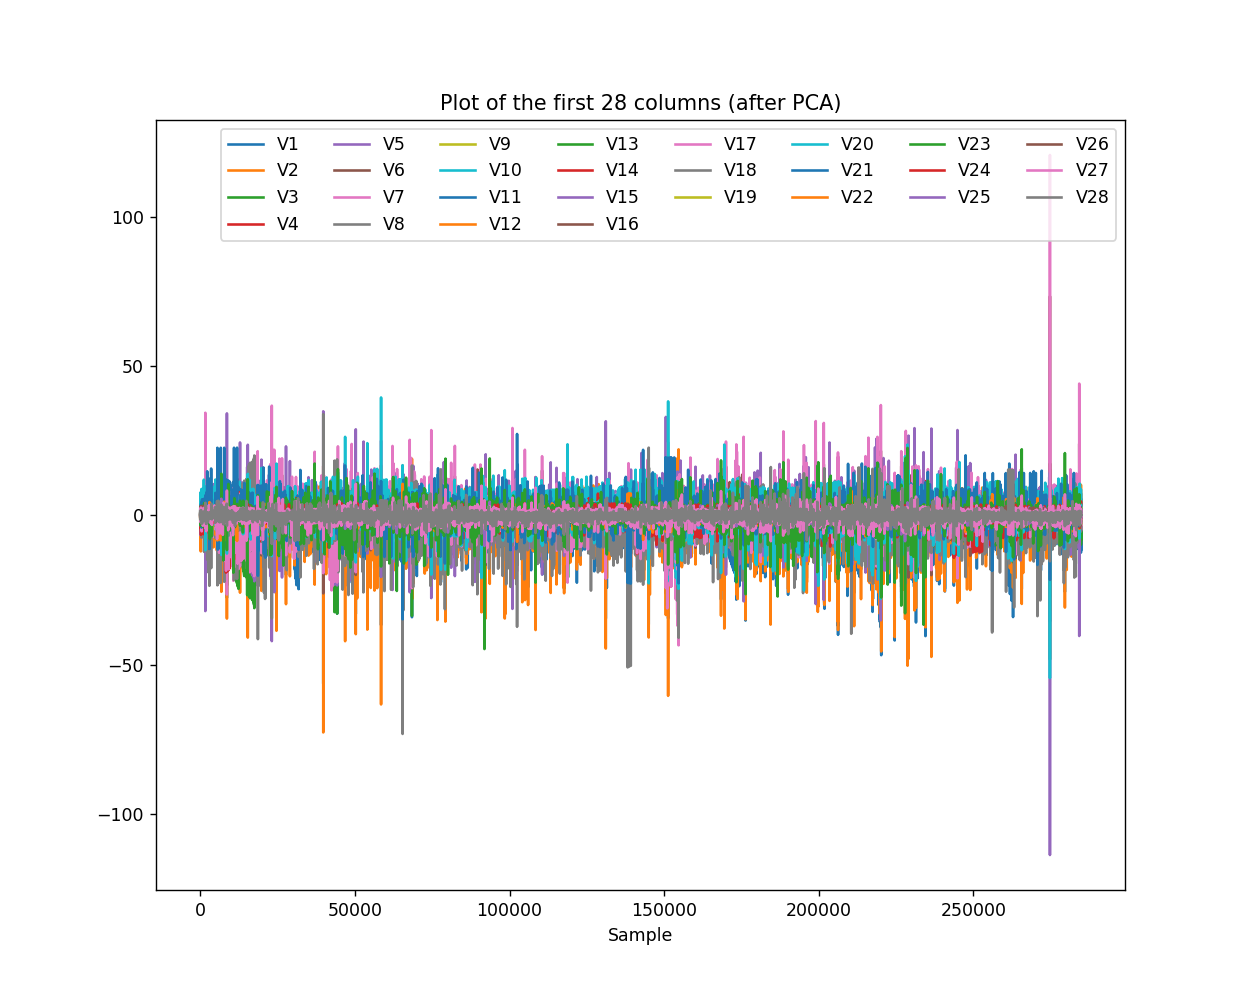

In [7]:
# Plot the features
# Takes a while to run

plt.figure(figsize=(10,8))
for a in range(1,29):
    plt.plot(data['V'+str(a)])
plt.legend(loc='best', fontsize=10, ncol=8)
plt.title("Plot of the first 28 columns (after PCA)")
plt.xlabel("Sample")

In [8]:
# How much fraud is there?

data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

<IPython.core.display.Javascript object>


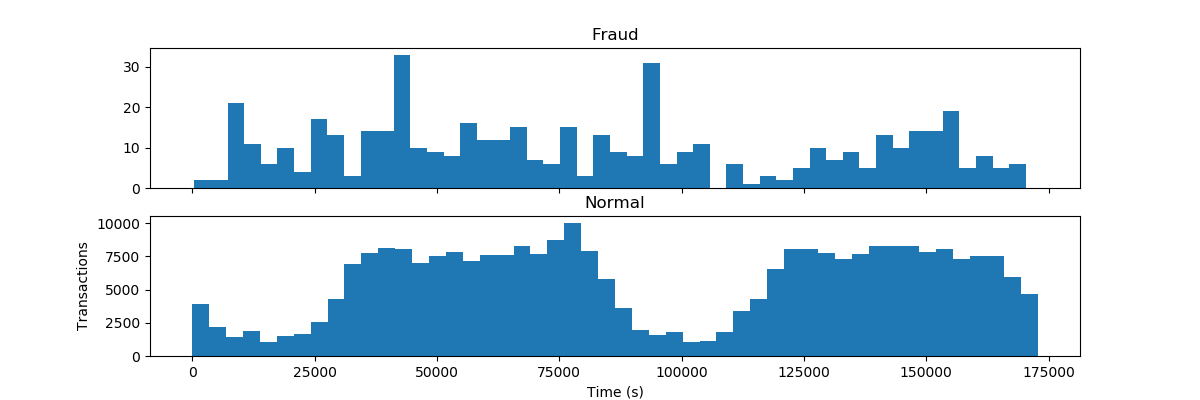

In [9]:
# Let's make histograms with Transactions against Time to see patterns

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.hist(data.Time[data.Class == 1], bins = 50)
ax1.set_title('Fraud')
ax2.hist(data.Time[data.Class == 0], bins = 50)
ax2.set_title('Normal')
plt.xlabel('Time (s)')
plt.ylabel('Transactions')
plt.show()

<IPython.core.display.Javascript object>


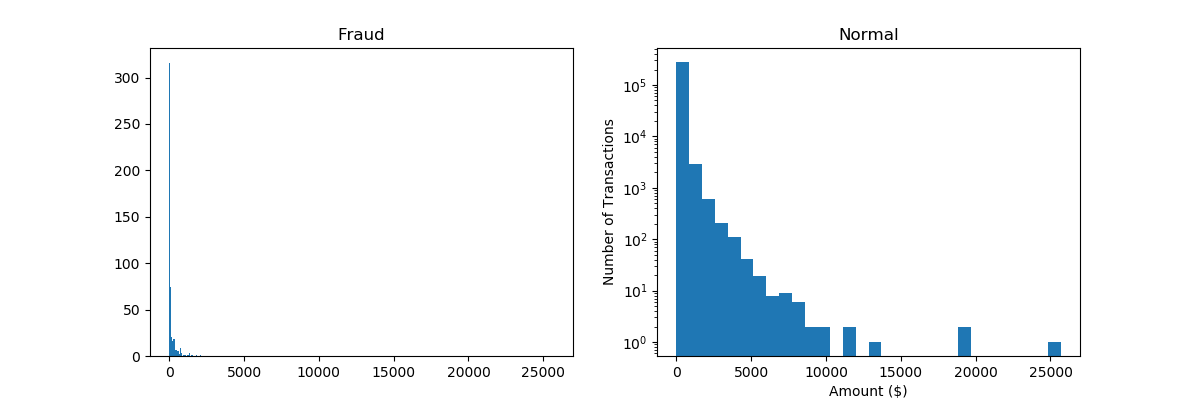

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,4))
ax1.hist(data.Amount[data.Class == 1], bins = 30)
ax1.set_title('Fraud')
ax2.hist(data.Amount[data.Class == 0], bins = 30)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()


<IPython.core.display.Javascript object>


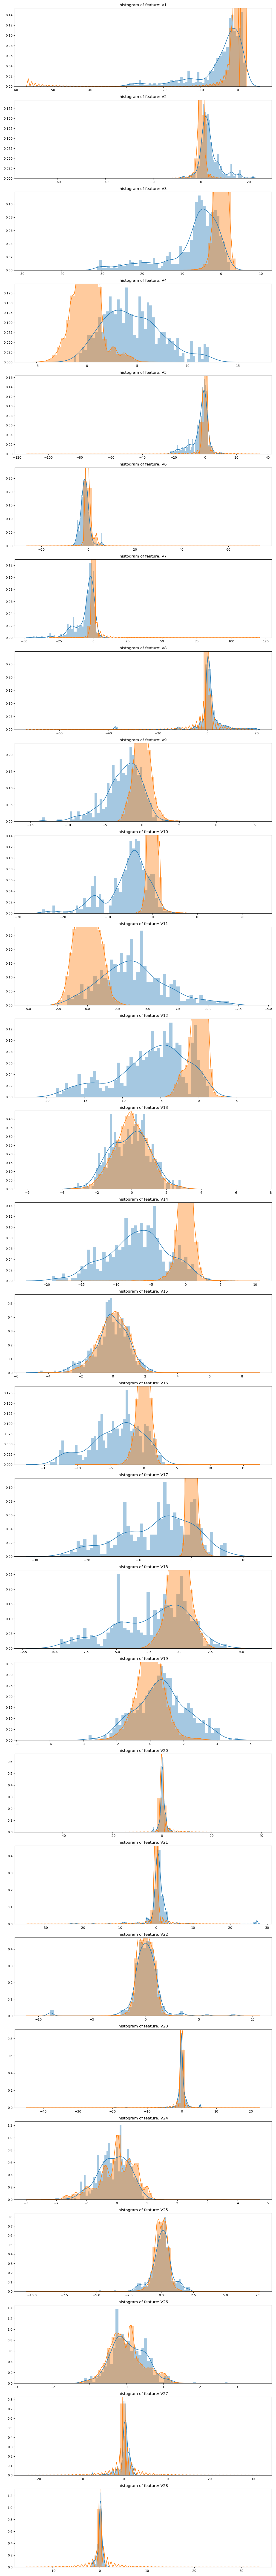

In [12]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i in range(1, 29):
    ax = plt.subplot(gs[i-1])
    sns.distplot(data['V'+str(i)][data.Class == 1], bins=50)
    sns.distplot(data['V'+str(i)][data.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + 'V'+str(i))
plt.show()
plt.tight_layout()

In [13]:
# Based on observation of data overlap above, try out a second dataset with redunancies removed
clean_data = data.drop(['V28','V27','V23','V8'], axis =1)
# Later - can re run everything after running the following line
#data = clean_data

In [ ]:
# Visualize the differences between 'data' and 'clean_data' using T-SNE

PREPARE DATASET

In [26]:
# Let's buid training and testing sets

df=clean_data

# Take equal amounts of fraud and non fraud
# We have 492 fraud values, so we will take 492 normal values

df1=df.loc[clean_data['Class'] == 1]
df0=df.loc[clean_data['Class'] == 0]
df0=df0.sample(n=492)

# Slap those dataframes together

frames = [df0, df1]
df=pd.concat(frames)

# Split into training and test data with 80/20

split = np.random.rand(len(df)) < 0.8
train = df[split]
test = df[~split]


In [31]:
# Check out the data sets

train
#test

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,...,V18,V19,V20,V21,V22,V24,V25,V26,Amount,Class
181988,125208.0,1.831469,-0.709944,-0.350708,0.291507,-0.415616,0.667367,-0.857244,0.985568,0.132625,...,0.731150,0.129253,0.059618,0.079680,0.176053,0.118396,-0.470674,0.143577,83.56,0
149650,91658.0,0.123423,0.234637,0.821727,-0.547396,0.365008,0.570231,-0.183835,2.058767,-0.989471,...,1.486258,-0.113773,-0.223920,0.107602,0.586930,0.011773,-0.298059,-0.334811,12.99,0
157294,109829.0,2.082359,0.048573,-1.358575,0.360051,0.321684,-0.742663,0.032101,2.095164,-0.467774,...,0.372572,-0.418560,-0.295384,0.109176,0.700305,0.556139,0.315860,-0.480242,1.00,0
109192,71263.0,0.356545,1.801049,-2.175759,1.567045,0.890332,-1.139982,0.422017,-0.775816,-1.290814,...,1.604803,-0.486536,-0.017939,-0.021083,0.044593,-0.330650,-0.538193,-0.386584,6.99,0
134329,80755.0,-0.821816,-0.804790,0.998334,-2.043697,2.854538,3.922647,0.735682,1.971885,0.938873,...,-0.311670,0.394752,-0.115577,-0.525327,-0.135551,1.086813,-0.963711,0.475723,60.00,0
43534,41547.0,-2.233061,0.652187,-0.115189,-1.759733,-2.435849,-1.046216,-1.271854,-3.112749,0.321220,...,0.042062,0.056462,-0.813976,-0.084845,-0.460720,0.355775,-0.083496,-0.402177,59.16,0
280108,169324.0,0.297988,0.373793,1.280719,1.006597,0.065623,0.437141,0.031932,0.494797,0.095258,...,0.801817,2.673481,0.329089,0.239474,1.194511,-0.649007,-0.814321,0.159353,9.99,0
243686,152029.0,-2.496409,1.155209,2.059694,0.267638,-1.705479,1.548954,-1.284707,1.012675,1.722580,...,1.660552,0.070881,0.434180,-0.462535,0.165391,0.677554,0.895838,-0.152561,35.00,0
197960,132255.0,2.012863,-0.061014,-0.994141,0.317443,-0.084875,-0.929951,0.119476,0.196201,0.226567,...,-0.468838,0.396921,-0.182445,-0.225309,-0.526696,0.091798,-0.323297,0.170920,1.98,0
244887,152529.0,1.940529,-0.782758,-0.692867,-1.400617,-0.856442,-0.955993,-0.372825,1.899050,-0.879327,...,-0.136034,1.328377,-0.121981,-0.313109,-0.730654,0.060212,-0.444375,-0.690241,41.69,0


In [33]:
import statsmodels.api as sm

train_cols = train.columns[1:]

logit = sm.Logit(data['Class'], data[train_cols])

# fit the model
result = logit.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix